In [1]:
import numpy as np
from scipy.ndimage import convolve
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.datasets import mnist, cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator


Convolution is an opeartion on two matrices $a = [a_1, a_0], b = [b_0, b_1, b_2, b_3, b_4]$ (a vector is reversed in a classical convolution)

$conv(b,a) = [a_0*b_0 + a_1 * b_1, a_0 * b_1 + a_1 * b_2, a_0 * b_2 + a_1 * b_3, a_0 * b_3 + a_1 * b_4]$

so we slide one matrix over the other and calculate a dot product

In [2]:
x1 = np.array([1, 2, 3, 4, 5])
x2 = np.array([1, 2])
np.convolve(x1, x2, mode='valid')

array([ 4,  7, 10, 13])

The resulting matrix will be smaller than the input due to the nature of the operation. We can force the output to be the same size as the input or apply a dot operation on each partially overlapping part. Then the result will be $[a_1 * b_0 + a_0*b_0 + a_1 * b_1, ..., a_0 * b_4]$ so it's an equivalent of using zero padding.

In [3]:
np.convolve(x1, x2, mode='same')

array([ 1,  4,  7, 10, 13])

In [4]:
np.convolve(x1, x2, mode='full')

array([ 1,  4,  7, 10, 13, 10])

Convolution can be used for 2 or more dimensional data. An example of how it is applied to a 2d matrix is presented below.

<img src="https://d29g4g2dyqv443.cloudfront.net/sites/default/files/pictures/2018/convolution-2.gif" width="750" align="center">

https://developer.nvidia.com/discover/convolution

Convolutions are widely used in image processing e.g. sobel filter can be used to detect edges.

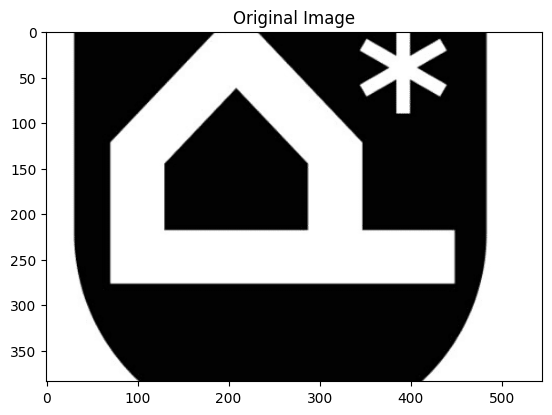

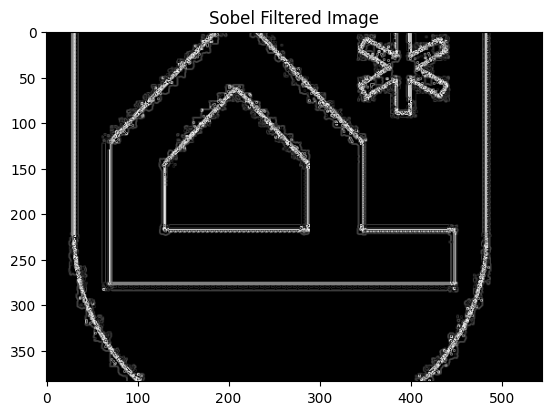

In [5]:
response = requests.get("https://filipnocny.pl/wp-content/uploads/2024/05/poznan-nowe-logo-545x384.png")
img = Image.open(BytesIO(response.content)).convert("L")  # Convert to grayscale
img_array = np.array(img)

sobel_x = np.array([[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]])

sobel_y = np.array([[-1, -2, -1],
                   [0, 0, 0],
                   [1, 2, 1]])

edges_x = convolve(img_array, sobel_x)
edges_y = convolve(img_array, sobel_y)
edges = np.sqrt(edges_x**2 + edges_y**2)


plt.imshow(img_array, cmap='gray')
plt.title('Original Image')
plt.show()

plt.imshow(edges, cmap='gray')
plt.title('Sobel Filtered Image')
plt.show()

Typically images are represented as a 3d matrix with e.g. RGB channels. The default approach would be to use 3d convolutions, however, since there is no spatial data to be extracted between channels we still use 2d convolutions with depth equal to the number of channels. So when applying a convolution on an image with a 3x3 kernel it is a 3x3x3 kernel.



Although powerful the filters are not easy to use. Which one to choose, and how to combine them it's not easy to do it manually so we want it to be done automatically and that's what convolutional neural networks are for. The weights model learns during the training are exactly the values of the convolutional filter.

In [6]:
x_size = 32
y_size = 32
dummy_dataset = np.random.randn(1, x_size, y_size, 3)
model = Sequential()
model.add(Conv2D(1, (3, 3), activation='relu', input_shape=(x_size, y_size, 3)))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 1)         28        
                                                                 
Total params: 28 (112.00 Byte)
Trainable params: 28 (112.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Our dataset consists of an image 32x32 with three channels. The model has one layer with one 'neuron'/filter of size 3x3(x3 - depth). It means 3*3*3=27 trainable parameters of the filter +1 parameter for bias. The output is of shape 30x30 since only 'valid' dot operations are performed.

In [7]:
x_size = 3200
y_size = 3200
dummy_dataset = np.random.randn(1, x_size, y_size, 3)
model = Sequential()
model.add(Conv2D(1, (3, 3), activation='relu', input_shape=(x_size, y_size, 3)))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 3198, 3198, 1)     28        
                                                                 
Total params: 28 (112.00 Byte)
Trainable params: 28 (112.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Due to the nature of the convolution, increasing the size of an input image does not result in a higher number of trainable parameters.

In [8]:
x_size = 3200
y_size = 3200
dummy_dataset = np.random.randn(1, x_size, y_size, 3)
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(x_size, y_size, 3)))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 3198, 3198, 32)    896       
                                                                 
Total params: 896 (3.50 KB)
Trainable params: 896 (3.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


If more 'neurons' are used each creates a new channel in the output, thus the number of channels is equal to the number of neurons.

Since the output is also in an image form (2d matrix with channels), the convolutional layers can be easily stuck.

In [9]:
x_size = 3200
y_size = 3200
dummy_dataset = np.random.randn(1, x_size, y_size, 3)
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(x_size, y_size, 3)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 3198, 3198, 32)    896       
                                                                 
 conv2d_4 (Conv2D)           (None, 3196, 3196, 32)    9248      
                                                                 
 conv2d_5 (Conv2D)           (None, 3194, 3194, 32)    9248      
                                                                 
Total params: 19392 (75.75 KB)
Trainable params: 19392 (75.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Due to the nature of the operation, we don't even have to specify the size of an input image if only convolutional layers are used.

In [10]:
x_size = 3200
y_size = 3200
dummy_dataset = np.random.randn(1, x_size, y_size, 3)
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(None, None, 3)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, None, None, 32)    896       
                                                                 
 conv2d_7 (Conv2D)           (None, None, None, 32)    9248      
                                                                 
 conv2d_8 (Conv2D)           (None, None, None, 32)    9248      
                                                                 
Total params: 19392 (75.75 KB)
Trainable params: 19392 (75.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

11490434/11490434 [==============================] - 118s 10us/step


Mnist is a popular dataset of handwritten digits. The aim is to predict which digit is in the picture.

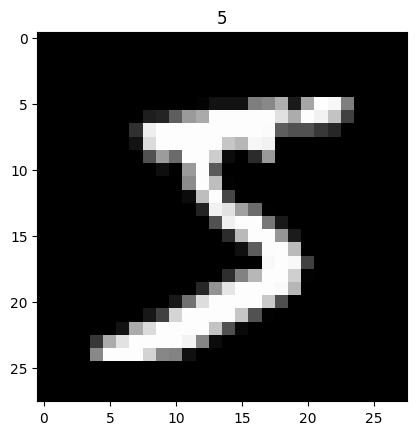

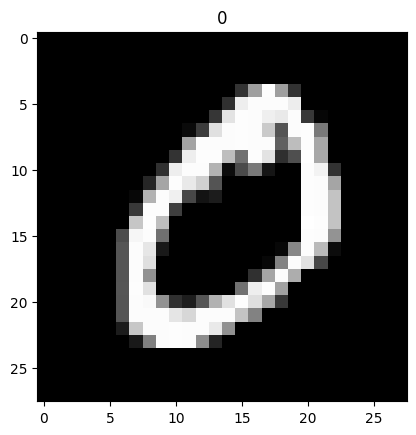

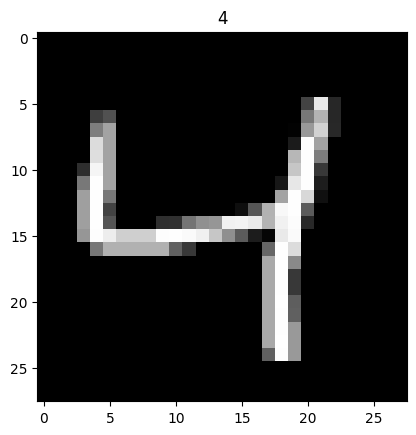

In [12]:
for i in range(3):
    plt.imshow(x_train[i].reshape(28, 28), cmap='gray')
    plt.title(y_train[i])
    plt.show()

In [13]:
x_size = 28
y_size = 28
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(x_size, y_size, 1)))
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(x_size, y_size, 1)))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 conv2d_10 (Conv2D)          (None, 24, 24, 32)        9248      
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 10)                184330    
                                                                 
Total params: 193898 (757.41 KB)
Trainable params: 193898 (757.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


We want to use conv layers to extract features and then at some point switch with these features to a classical MLP. The aim of a Flatten function is to transform the 3d output (2d image with channels) to a flat vector that can be an input to a MLP.

In [14]:
model.fit(x_train, y_train, epochs=1, batch_size=256, validation_split=0.1)
model.evaluate(x_test, y_test)

313/313 [==============================] - 2s 6ms/step - loss: 0.0819 - accuracy: 0.9750


[0.08187295496463776, 0.9750000238418579]

As you can see the size of an image decreases slowly with each layer, therefore after applying the Flatten layer the size of the obtained vector is quite big. To make the process faster an operation called Pooling can be used. It can be seen as an image size reduction. Different types of Pooling can be used e.g. Max or Average, Max is the most popular due to its efficiency. The procedure is simple, assuming we have an input image 4x4 and use MaxPooling with kernel 2x2 the input is divided into 4 squares of the same size as the kernel, and from each the max value is extracted.

<img src="https://production-media.paperswithcode.com/methods/MaxpoolSample2.png" width="750" align="center">

https://paperswithcode.com/method/max-pooling

In [15]:
x_size = 28
y_size = 28
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(x_size, y_size, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_12 (Conv2D)          (None, 11, 11, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 32)          0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 800)               0         
                                                                 
 dense_1 (Dense)             (None, 10)               

Now the model is much smaller and will learn faster. The difference is much higher when dealing with big images.

In [16]:
model.fit(x_train, y_train, epochs=2, batch_size=256, validation_split=0.1)
model.evaluate(x_test, y_test)

Epoch 1/2
211/211 [==============================] - 13s 61ms/step - loss: 0.5214 - accuracy: 0.8612 - val_loss: 0.1201 - val_accuracy: 0.9685
Epoch 2/2
313/313 [==============================] - 1s 4ms/step - loss: 0.0793 - accuracy: 0.9771


[0.07928099483251572, 0.9771000146865845]

## Task 1
Try to get the best score with different architectures

## Task2
Create a model to distinguish cats and dogs.

Typically we normalize data before using a neural network. It makes the learning process easier and faster. We can include this procedure inside a network. After each layer the values are transformed and no longer standardized. We can again normalize them using BatchNormalization after each transformation (convolution). You can check how adding this layer affects the learning process.

Dropout is a popular technique to prevent overfitting. It randomly turns off (drops out) a given fraction of outputs from the previous layer. You can try to apply it if the model performs significantly better on the training set compared to the validation one.

170498071/170498071 [==============================] - 511s 3us/step


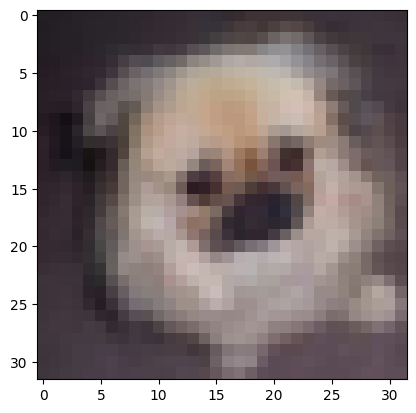

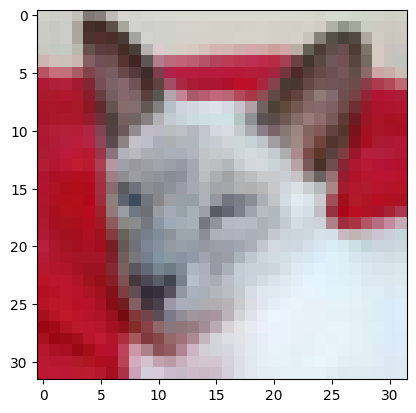

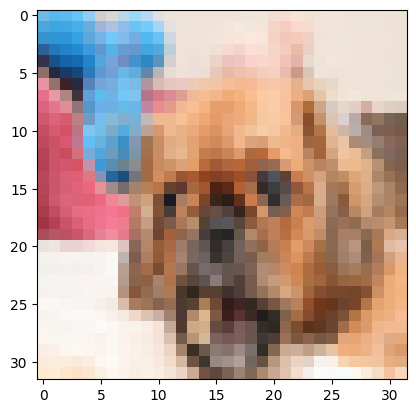

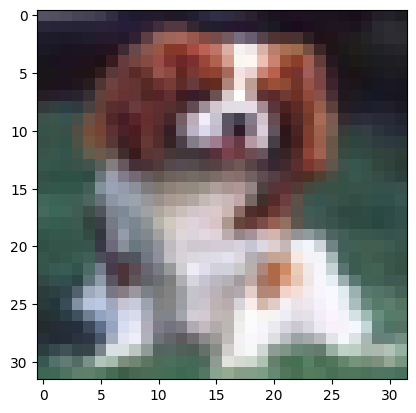

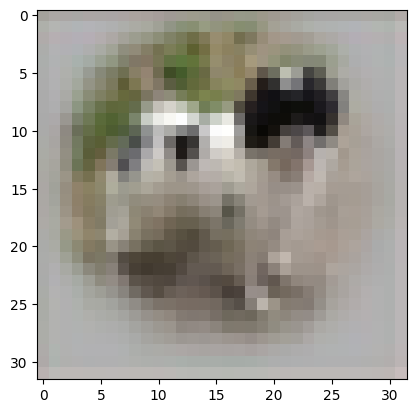

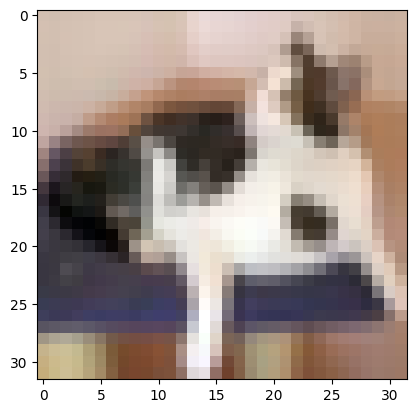

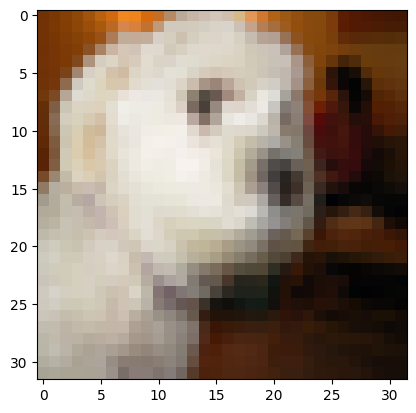

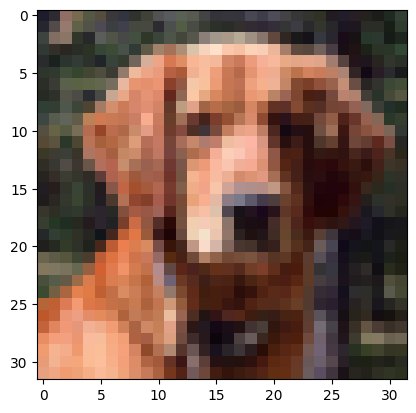

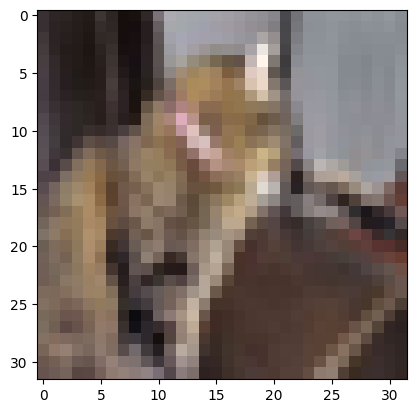

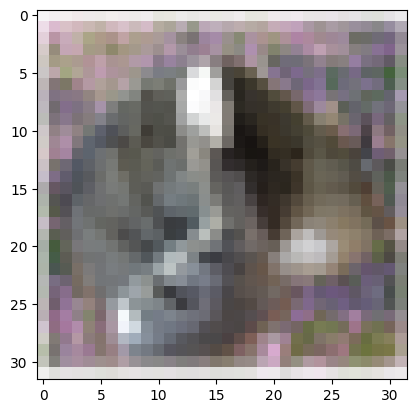

In [17]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train = y_train[..., 0]
y_test = y_test[..., 0]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

classes = [3, 5]
x_train = x_train[np.isin(y_train, classes)]
y_train = y_train[np.isin(y_train, classes)]
x_test = x_test[np.isin(y_test, classes)]
y_test = y_test[np.isin(y_test, classes)]

y_train = np.where(y_train == 3, 0, 1)
y_test = np.where(y_test == 3, 0, 1)

for x in np.random.randint(0, len(x_train), 10):
    plt.imshow(x_train[x])
    plt.show()

In machine learning and especially in deep learning the rule of thumb says the more data the better, of course, the quality of the data is also very important. With images, it's very easy to extend the dataset by performing simple operations like rotation, shift, gamma correction, etc. This process is called data augmentation. There are ready-to-use tools supporting the process, however, it's not recommended to use them without any analysis. For example, in the mnist dataset it makes no sense to flip the image since the result of this operation is not something we expect in the dataset.

In [24]:
response = requests.get("https://filipnocny.pl/wp-content/uploads/2024/05/poznan-nowe-logo-545x384.png")
img = Image.open(BytesIO(response.content))
x = np.array(img)

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest'
)
x = x.reshape((1,) + x.shape)
batch = datagen.flow(x)
for i, x in enumerate(batch):
  plt.imshow(x[0].astype(int))
  plt.title(f'Augmented Image {i}')
  plt.show()
  if i > 6:
    break


ValueError: ('Input data in `NumpyArrayIterator` should have rank 4. You passed an array with shape', (1, 384, 545))

## Task 3

Use data augmentation and data generator to train the best model you can. If you want you can use a dataset with better images e.g. https://www.microsoft.com/en-us/download/details.aspx?id=54765